In [1]:
import json
import pickle
import re
import collections
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from random import randint
import sys
import math
from scipy import spatial,sparse
import random

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
ff_path = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\ff_of_rep\\'
path = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\'

In [3]:
# vocabulary?
filenames = [f for f in listdir(ff_path) if isfile(join(ff_path, f))]

In [16]:
def sample_from_candidates(ff_path, filenames,seed):
    
    candidate_sp = []  # use this to test my PLSA model
    random.seed(seed)
    
    for file in filenames:
        try:
            with open(ff_path + file,'rb') as f:
                candidate = pickle.load(f)

                # too big to process, sampling 100 followers from each representative nodes
                for c in random.sample(set(candidate),100):
                    if c not in candidate_sp:
                        candidate_sp.append(c)

        except EOFError:
            print(file)
            pass
        
    return candidate_sp

In [71]:
path_test1 = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\test1\\'

candidate_sp1 = sample_from_candidates(ff_path,filenames,seed = 0)
candidate_sp2 = sample_from_candidates(ff_path,filenames,seed = 1)
candidate_sp3 = sample_from_candidates(ff_path,filenames,seed = 2)
with open(path_test1 + 'candidate_sp1.pickle','wb+') as f:
    pickle.dump(candidate_sp1,f)
with open(path_test1 + 'candidate_sp2.pickle','wb+') as f:
    pickle.dump(candidate_sp2,f)
with open(path_test1 + 'candidate_sp3.pickle','wb+') as f:
    pickle.dump(candidate_sp3,f)
with open(path_test1 + 'represent_id.pickle','rb') as f:
    feature = pickle.load(f)

In [78]:
with open(path_test1 + 'candidate_sp1.pickle','rb') as f:
    candidate_sp1 = pickle.load(f)
with open(path_test1 + 'candidate_sp2.pickle','rb+') as f:
    candidate_sp2 = pickle.load(f)
with open(path_test1 + 'represent_id.pickle','rb') as f:
    feature = pickle.load(f)

# construct a vector

In [79]:
def construct_vector(candidate_list,feature):
    
    V = dict((c,np.zeros(len(feature),)) for c in candidate_list)

    for i in range(len(feature)):  
        with open(ff_path + str(feature[i]) + '.pickle','rb') as f:

                candidate = pickle.load(f)

                for c in candidate:
                    if c in V.keys():
                        #print('true')
                        V[c][i] = 1 
    return V

In [80]:
Vector1 = construct_vector(candidate_sp1,feature)
Vector2 = construct_vector(candidate_sp2,feature)
# Vector3 = construct_vector(candidate_sp3,feature)

# test block to see how sparse the matrix is

In [26]:
def test_sparsity(V,feature_num):
    for v in list(V.keys()):
        total_feature = np.sum(V[v])
        if total_feature >= feature_num:
            print('user_id:', v,'\t\ttotal feature:', total_feature)
    return None

In [27]:
test_sparsity(Vector1,40)
test_sparsity(Vector2,40)
test_sparsity(Vector3,40)

user_id: 781149191808712704 		total feature: 46.0
user_id: 791068282736484352 		total feature: 49.0
user_id: 791068282736484352 		total feature: 49.0


# Build Classifier
<img src=untitled.png>

In [86]:
with open(path_test1 + 'prob_following_rep.pickle','rb') as f:
    prob = pickle.load(f)

In [98]:
def NB_rank_candidate(V, feature, penalty=True):
    
    candidate_score = {}

    for v in list(V.keys()):  # for each user
        
        score = 0
        for i in range(len(feature)): # for each feature            

            if V[v][i] == 1:  # if follow
                score += math.log2(prob[0][i]) # ln(p(follow)) 
                
            if penalty == True:
                if V[v][i] == 0:
                    score += math.log2(prob[1][i]) # ln(p(unfollow))

        candidate_score[v] = score
    
    NB_candidate_score = sorted(candidate_score.items(),key=lambda x:x[1],reverse=True)
    
    return NB_candidate_score

In [106]:
NB_p_rank_sp1 = NB_rank_candidate(Vector1, feature, penalty=True)
NB_p_rank_sp2 = NB_rank_candidate(Vector2, feature, penalty=True)
with open (path_test1 + 'NB_p_rank_sp1.pickle', 'wb+') as f:
    pickle.dump(NB_p_rank_sp1,f)
with open (path_test1 + 'NB_p_rank_sp2.pickle', 'wb+') as f:
    pickle.dump(NB_p_rank_sp2,f)

In [107]:
NB_rank_sp1 = NB_rank_candidate(Vector1, feature, penalty=False)
NB_rank_sp2 = NB_rank_candidate(Vector2, feature, penalty=False)
with open (path_test1 + 'NB_rank_sp1.pickle', 'wb+') as f:
    pickle.dump(NB_rank_sp1,f)
with open (path_test1 + 'NB_rank_sp2.pickle', 'wb+') as f:
    pickle.dump(NB_rank_sp2,f)

In [108]:
def plot_ranks(rank,Vector,title,fname):
    
    n_f = []  # total number of features
    for c in rank:
        n_f.append(np.sum(Vector[c[0]]))

    x = range(1,len(n_f)+1)
    y = n_f

    fig, axes = plt.subplots(figsize=(10,10))

    axes.plot(x,y)
    axes.set_xlabel('ranked candidate ' + str(len(rank)))
    axes.set_ylabel('total number of feature')
    axes.set_title(title, fontsize = 20)
    #axes.set_ylim([1,40])
    #axes.set_xlim([0,30000])

    plt.show()
    
    #fig = plt.figure()
    fig.savefig(fname)

    return None

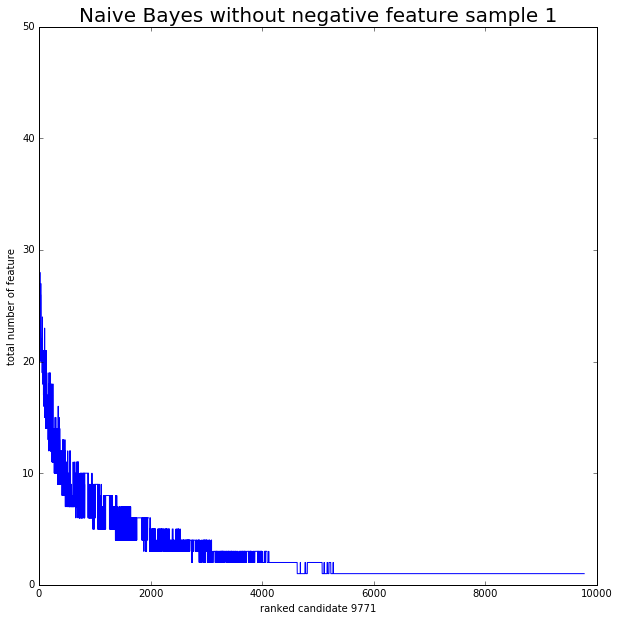

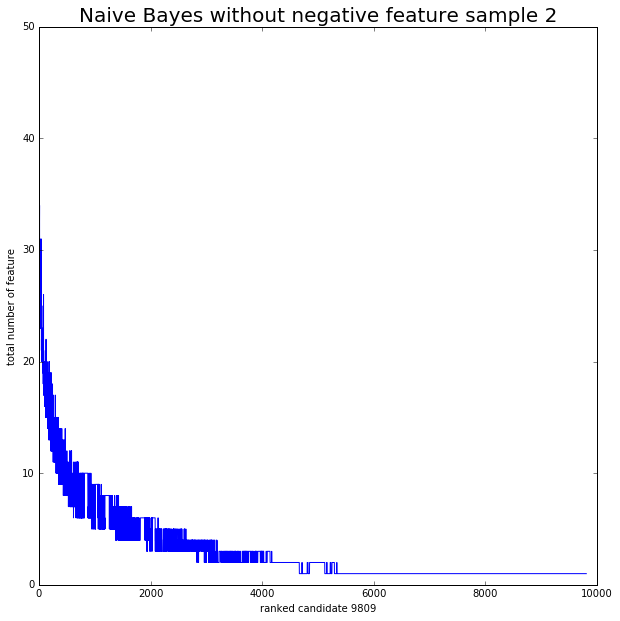

In [111]:
plot_ranks(NB_rank_sp1,Vector1,'Naive Bayes without negative feature sample 1', path_test1+'NB_feature_sp1.png')
plot_ranks(NB_rank_sp2,Vector2,'Naive Bayes without negative feature sample 2', path_test1+'NB_feature_sp2.png')

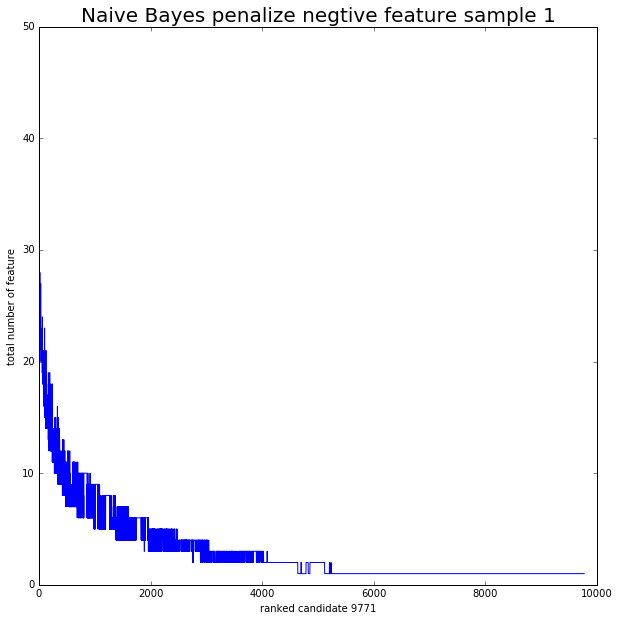

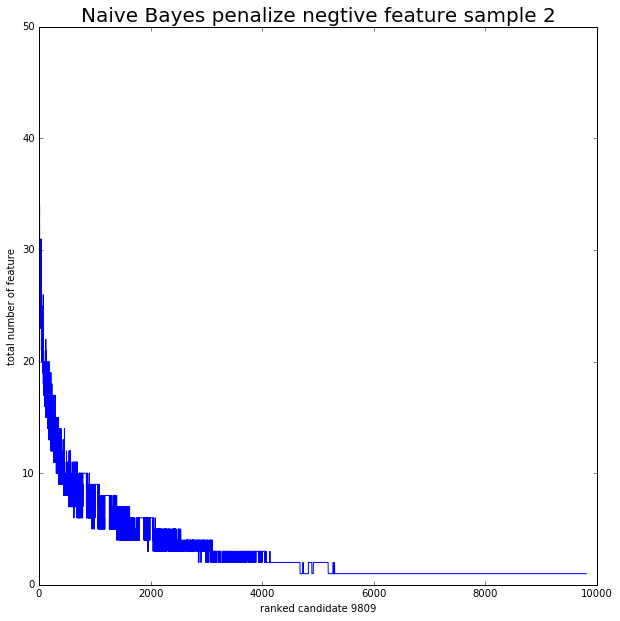

In [110]:
plot_ranks(NB_p_rank_sp1,Vector1,'Naive Bayes penalize negtive feature sample 1', path_test1+'NB_p_feature_sp1.png')
plot_ranks(NB_p_rank_sp2,Vector2,'Naive Bayes penalize negtive feature sample 2', path_test1+'NB_p_feature_sp2.png')

# Vector space model approach
similarity = cosine similarity?


In [60]:
with open(path_test1 + 'weight_rep.pickle','rb') as f:
    weight_vector = pickle.load(f)

In [62]:
def cosine_similarity(V, weight):
    similarity = {}
    feature_vector = np.ones((1,100))
    #print(feature_vector)
                      
    for v in list(V.keys()):  # for each user
        if weight != None:
            V_weighted = np.multiply(V[v],weight_vector)
            similarity[v] = 1 - spatial.distance.cosine(V_weighted, weight)
        else:
            similarity[v] = 1 - spatial.distance.cosine(V[v],feature_vector)

    sim_ranked = sorted(similarity.items(),key=lambda x:x[1],reverse=True)
    
    return sim_ranked

In [64]:
w_sim_rank_sp1 = cosine_similarity(Vector1, weight_vector)
w_sim_rank_sp2 = cosine_similarity(Vector2, weight_vector)
sim_rank_sp1 = cosine_similarity(Vector1,None)
sim_rank_sp2 = cosine_similarity(Vector2,None)

In [67]:
with open(path_test1 + 'weighted_sim_rank_sp1.pickle','wb+') as f:
    pickle.dump(w_sim_rank_sp1,f)
with open(path_test1 + 'weighted_sim_rank_sp2.pickle','wb+') as f:
    pickle.dump(w_sim_rank_sp2,f)
    
with open(path_test1 + 'unweighted_sim_rank_sp1.pickle','wb+') as f:
    pickle.dump(sim_rank_sp1,f)
with open(path_test1 + 'unweighted_sim_rank_sp2.pickle','wb+') as f:
    pickle.dump(sim_rank_sp2,f)    

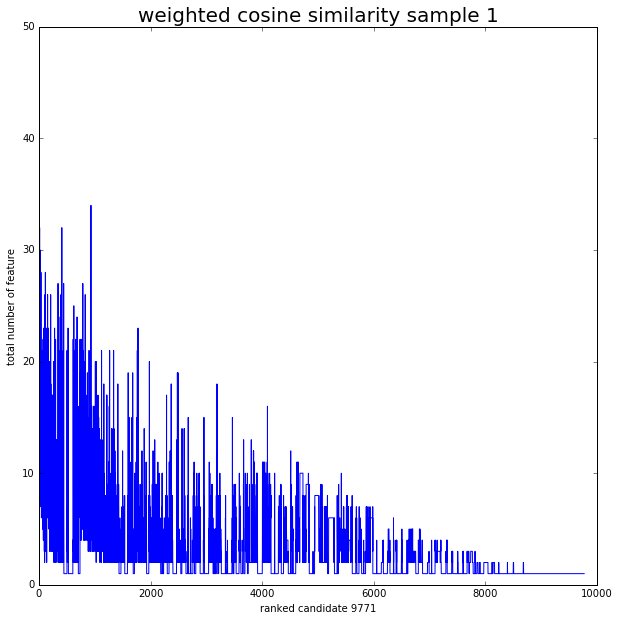

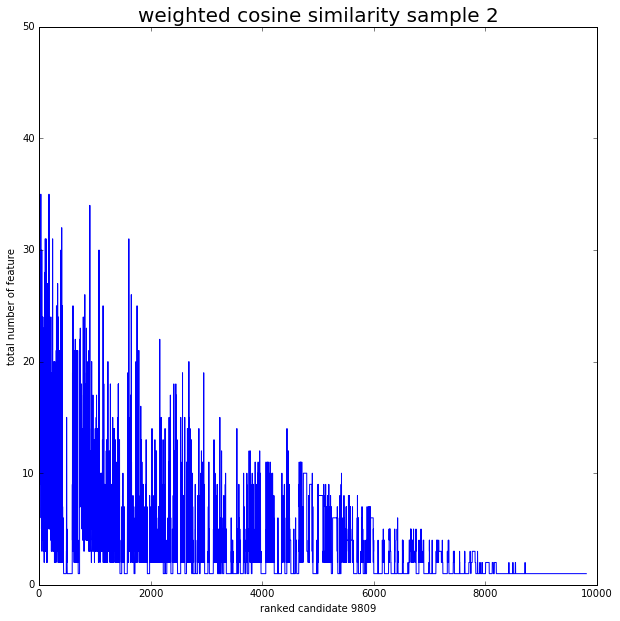

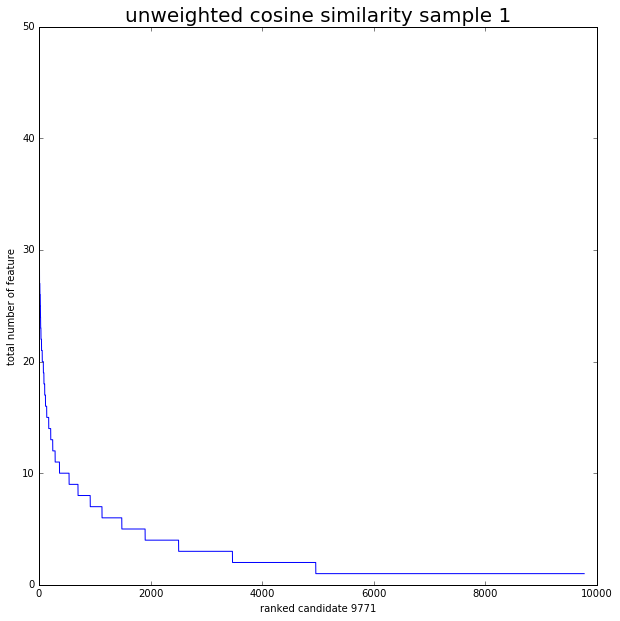

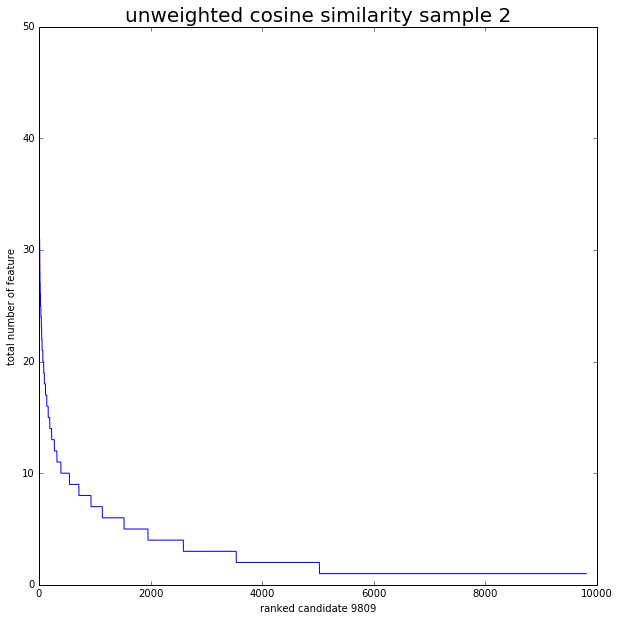

In [70]:
plot_ranks(w_sim_rank_sp1,Vector1,'weighted cosine similarity sample 1', path_test1+'w_feature_sp1.png')
plot_ranks(w_sim_rank_sp2,Vector2,'weighted cosine similarity sample 2', path_test1+'w_feature_sp2.png')
plot_ranks(sim_rank_sp1,Vector1,'unweighted cosine similarity sample 1', path_test1+'u_feature_sp1.png')
plot_ranks(sim_rank_sp2,Vector2,'unweighted cosine similarity sample 2', path_test1+'u_feature_sp2.png')

# labeling data

In [7]:
with open(path_test1 + 'location_list_sp1.pickle','rb') as f:
    location_sp1 = pickle.load(f)

In [9]:
candidate_w_loc = []
for loc in location_sp1.keys():
    if location_sp1[loc] != 'NaN':
        candidate_w_loc.append((loc,location_sp1[loc].lower()))

In [53]:
random.seed(0)
X_train = random.sample(set(candidate_w_loc),1000)

In [18]:
with open(path_test1 + 'X_train.pickle','wb+') as f:
    pickle.dump(X_train,f)

In [54]:
X_train[:10]

[(753823407284719616, 'tupelo, ms'),
 (632559354, 'sioux city, ia'),
 (762751866748801024, 'phoenix, az'),
 (739989673997570049, 'san antonio, tx'),
 (788056332767232000, 'mississippi, usa'),
 (46148356, 'chicago'),
 (4708505475, 'my world our world'),
 (18435438, 'atlanta, ga'),
 (743267552432898048, 'illinois, usa'),
 (790245981447225344, 'νεο ηρακλειο, ελλας')]

In [55]:
df_X_train = pd.DataFrame(X_train,columns = ['id','location'])

In [56]:
chicago = ['chicago','Arlington Heights', 'Aurora', 'Berwyn', 'Bolingbrook', 'Cicero','Des Plaines', 'Elgin','Evanston', 'Gary', 'Hammond',
           'Hoffman Estates', 'Joliet', 'Kenosha', 'Mount Prospect','Naperville', 'Oak Lawn', 'Oak Park', 'Orland Park',
           'Palatine', 'Schaumburg','Skokie','Tinley Park','Waukegan','Wheaton']#,', IL','Illinois']

In [57]:
df_X_train['label'] = 0
for chi in chicago:
    df_X_train.loc[df_X_train.location.str.contains(chi.lower()), 'label'] = 1

In [23]:
# save the id of these temp 1 labeled to a list, query twitter user_timeline to see their tweets
training_chicago_id = df_X_train[df_X_train.label ==1]['id'].tolist()
with open(path_test1 + 'training_id.pickle','wb') as f:
    pickle.dump(training_chicago_id,f)

In [58]:
df_X_train.shape

(1000, 3)

In [110]:
rel_id_train = [46148356,1283267196,30254145,733152516683247616,44423405,176232700,1241637750,\
          621522914,43530424,752306004872851456,975450122,2924408380,770351285178695680,\
          37336702,164062745,717508616379621377,1345613311,3734726776,789699096,849617023,\
          701371958,293753781,2548145526,24795305,710161008623374336,257957627,2270087558,\
          775889513545687040,37945675,3025453876,403494826,97968287,25233272,2941297534,\
          2830084011,1684267350,126124444,615610761,36873535,431079779,763708110817157120,\
          311828546,342126885,30322075,742489204811304961,4108695973,14626348,3572689408,\
          718203801061191681,409459019,47487197,439410532,2788845642,30070994,4156754953,\
          100859077,762437132,90691208,44395175,3127628843,29291060,1270251462,1499761044,\
          22333466,266218183,218158603,26409269,250316672,190070843,242518175,1949440105,\
          344756733,781246329125306369,27038618,185417089,215002856,786755345876213761,22925169,\
          2922020171, 59367817,25031566,789270782711042048,2905598754,774009692439846912,18744284,58543233]

In [111]:
df_X_train.loc[~(df_X_train['id'].isin(rel_id_train)),'label'] = 0

In [61]:
with open(path_test1 + 'train_no_info.pickle','rb') as f:
    no_info = pickle.load(f)

In [62]:
df_X_train = df_X_train.loc[~(df_X_train['id'].isin(no_info))]

In [147]:
df_X_train[df_X_train.label==1]

,id,location,label
5,46148356,chicago,1
13,1283267196,"chicago, il",1
46,30254145,"waukegan, il",1
50,733152516683247616,"elgin, il",1
72,44423405,chicago,1
80,176232700,chicago,1
100,1241637750,"chicago, il",1
109,621522914,chicago to scottsdale,1
116,43530424,"the pit/evanston,il",1
123,752306004872851456,"chicago, il",1


In [125]:
# setting up training sets
target_train = df_X_train['label'].tolist()
id_train = df_X_train['id'].tolist()
feature_train = []
for id in id_train:
    feature_train.append(Vector1[id])

In [126]:
# setting up testing sets
id_test = []
for x in candidate_sp1:
    if x not in id_train:
        id_test.append(x)
feature_test = []       
for id in id_test:
    feature_test.append(Vector1[id])

# classification

In [158]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
def classification(clf, X_train, Y_train, X_test,id_test):
    clf.fit(X_train,Y_train)
    target_test = clf.predict(X_test)
    df_y_test = pd.DataFrame(id_test,columns=['id'])
    df_y_test['label'] = target_test
    rel_id_test = df_y_test[df_y_test['label']==1]['id'].tolist()
    irrel_id_test = df_y_test[df_y_test['label']==0]['id'].tolist()
    
    return df_y_test,rel_id_test,irrel_id_test

In [140]:
clf = BernoulliNB()
df,rel_id,irrel_id = classification(clf,feature_train,target_train,feature_test,id_test)
with open(path_test1 + 'clf_NB_test_rel.pickle','wb+') as f:
    pickle.dump(rel_id,f)
with open(path_test1 + 'clf_NB_test_irrel.pickle','wb+') as f:
    pickle.dump(irrel_id,f)

In [141]:
clf = DecisionTreeClassifier()
df,rel_id,irrel_id = classification(clf,feature_train,target_train,feature_test,id_test)
with open(path_test1 + 'clf_DT_test_rel.pickle','wb+') as f:
    pickle.dump(rel_id,f)
with open(path_test1 + 'clf_DT_test_irrel.pickle','wb+') as f:
    pickle.dump(irrel_id,f)

In [152]:
clf = KNeighborsClassifier(n_neighbors=1)
df,rel_id,irrel_id = classification(clf,feature_train,target_train,feature_test,id_test)
with open(path_test1 + 'clf_KNN_test_rel.pickle','wb+') as f:
    pickle.dump(rel_id,f)
with open(path_test1 + 'clf_KNN_test_irrel.pickle','wb+') as f:
    pickle.dump(irrel_id,f)

In [155]:
# something is wrong here
clf = SVC()
df,rel_id,irrel_id = classification(clf,feature_train,target_train,feature_test,id_test)
with open(path_test1 + 'clf_SVC_test_rel.pickle','wb+') as f:
    pickle.dump(rel_id,f)
with open(path_test1 + 'clf_SVC_test_irrel.pickle','wb+') as f:
    pickle.dump(irrel_id,f)

In [196]:
clf = GradientBoostingClassifier(n_estimators=100,learning_rate=1, max_depth=1, random_state=10)
df,rel_id,irrel_id = classification(clf,feature_train,target_train,feature_test,id_test)
with open(path_test1 + 'clf_GBC_test_rel.pickle','wb+') as f:
    pickle.dump(rel_id,f)
with open(path_test1 + 'clf_GBC_test_irrel.pickle','wb+') as f:
    pickle.dump(irrel_id,f)

In [180]:
# clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
clf = MLPClassifier(hidden_layer_sizes=(100,), learning_rate = 'adaptive', random_state = 0,max_iter=1000)
df,rel_id,irrel_id = classification(clf,feature_train,target_train,feature_test,id_test)
with open(path_test1 + 'clf_NNW_test_rel.pickle','wb+') as f:
    pickle.dump(rel_id,f)
with open(path_test1 + 'clf_NNW_test_irrel.pickle','wb+') as f:
    pickle.dump(irrel_id,f)

# questions: 

begining of Oct

1. for initial list:
I applied very stringent approach (only look at user profile who provides 'chicago' as their location). Reasonable? Extra learning required?

2. feature selection:
How many representative nodes do we need?

3. feature ranking:
My approach reasonable? Any improvement?

4. rate limit problem
when use the clf on test data, need to retrieve test nodes's friends_list. thus only can test a small portion once a time.
can't be real time very slow

5. is this approach generic enough? 
chicago is famous. What if it's non-famous? what if it's smaller or bigger area?

6. How to utilize the query user by keyword?

7. How to test the performance? 
We hae ground truth (a small portion of user will list their profile location <10%)

# Things to do:
a. SVD rank feature 

b. haven\'t add prior to naive bayes

c. think!

I have different goal than Amin's approach.
--------------------------------------------------------------------------------------------------------
representatives:
(1) Amin's approach is very time consuming, might hit a lot of rate limit. imagine loop over 150,000+ people, query their followers to get the "follower number"
(2) filter the top 200 frequent "TF" potential candidate by their location? might sacrifice some representatives that doesn't explicitly list their location? Still consuming, hit rate limit 

Difference of Amin's goal and my goal
he wants to find interest, i want to find location. I have more information than he has. How can I utilize these information.

# estimate prior
<img src= 'prior.png'>

i feel like this prior wont affect ranking so can be omit, doesnt change with Ux